# Восстановление золота из руды

Задача проекта подготовить прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В нашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Задачи:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.


В нашем распоряжении три датасета с числовыми признаками разных стадий обработки руды. Обучающая и тестовая выборки, и исходный датасет, содержащий обучающую и тестовую выборки со всеми признаками.

В ходе проекта нужно спрогнозировать две величины:
- эффективность обогащения чернового концентрата rougher.output.recovery;
- эффективность обогащения финального концентрата final.output.recovery.

Рассчитать итоговую метрику из этих двух величин.

Подобрать модель, предсказывающую коэффициент восстановления золота из золотосодержащей руды.

В ходе проекта планируется:
- исследовать данные,
- проверить эффективность обогащения для признака rougher.output.recovery, посчитав метрику MAE между расчётами и значением признака,
- сравнить выборки и корректность их выгрузки,
- провести предобработку данных,
- исследовать концентрацию металлов (Au, Ag, Pb) на разных стадиях обработки,
- сравнить распределения размеров гранул сырья на обучающей и тестовой выборках,
- обучить разные модели и оценить их качество кросс-валидацией, лучшую модель проверить на тестовой выборке.


Данные содержат следующие признаки:

- id — уникальный идентификатор скважины;
- f0, f1, f2 — параметры;

Целевые признаки: rougher.output.recovery, final.output.recovery.

## Подготовка данных

In [97]:
import pandas as pd
import numpy as np

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

In [98]:
state = np.random.RandomState(12345)

Загрузим данные:

In [99]:
try:
    gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    gold_recovery_train = pd.read_csv('datasets/gold_recovery_train_new.csv')
    gold_recovery_test = pd.read_csv('datasets/gold_recovery_test_new.csv')
    gold_recovery_full = pd.read_csv('datasets/gold_recovery_full_new.csv')

Посмотрим на их содержание:

In [100]:
def get_data_analysis(data):
    display(data.head())
    print('\n')
    data.info()
    print('\n')
    print(f'Кол-во дубликатов равно = {data.duplicated().sum()}')
    print('\n')
    data.hist(bins=25, figsize=(30,100), layout=(29,3))
    plt.show()
    print('\n', '========'*10)

#for data in [gold_recovery_train, gold_recovery_test, gold_recovery_full]:
#    get_data_analysis(data)

Есть пропущенные значения в признаках, дубликатов не обнаружено, а также имеются выбросы.

Посмотрим на соотношение обучающей и тестовой выборок:

In [101]:
gold_recovery_test.shape[0]/gold_recovery_train.shape[0]

0.3738780125803944

In [102]:
gold_recovery_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


Соотношение близко к 1:3. Можно использовать без изменений.

Формула для расчета эффективности обогащения:

In [103]:
def recovery(C, F, T):
    return ((C * (F - T)) / (F * (C - T)) * 100)

Зададим значения переменных для признака rougher.output.recovery:

In [104]:
C_rougher = gold_recovery_train['rougher.output.concentrate_au']
F_rougher = gold_recovery_train['rougher.input.feed_au']
T_rougher = gold_recovery_train['rougher.output.tail_au']

In [105]:
rougher_recovery = recovery(C_rougher, F_rougher, T_rougher)

In [106]:
mae_rougher = mean_absolute_error(
    gold_recovery_train['rougher.output.recovery'], 
    rougher_recovery
)

print('MAE для эффективности обогащения на обучающей выборке для признака rougher.output.recovery:{}'.format(mae_rougher))

MAE для эффективности обогащения на обучающей выборке для признака rougher.output.recovery:9.73512347450521e-15


Значение очень близко к нулю, поэтому можно считать, что данные указаны верно

Зададим значения переменных для признака final.output.recovery:

In [107]:
C_final = gold_recovery_train['final.output.concentrate_au']
F_final = gold_recovery_train['rougher.input.feed_au']
T_final = gold_recovery_train['final.output.tail_au']

In [108]:
final_recovery = recovery(C_final, F_final, T_final)

In [109]:
mae_final = mean_absolute_error(
    gold_recovery_train['final.output.recovery'], 
    final_recovery
)

print('MAE между расчётами и значением признака {}'.format(mae_final))

MAE между расчётами и значением признака 8.538049763979541e-15


Значение очень близко к нулю, поэтому можно считать, что данные указаны верно

Сравним признаки обучающей и тестовой выборок:

In [110]:
list_columns = sorted(list(set(gold_recovery_train.columns) - set(gold_recovery_test)))
list_columns

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

В тестовой выборке отсутствуют данные с параметрами продукта. Это необходимо учесть в обучающей выборке при обучении моделей. А также в тестовой выборке отсутсвуют целевые признаки.

Изучим пропущенные значения:

In [111]:
pd.set_option('display.max_columns', 100)
gold_recovery_full.loc[gold_recovery_full['secondary_cleaner.state.floatbank2_a_air'].isnull()].head(20)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
114,2016-01-21 10:00:00,5.782224,10.969985,9.301260,43.181003,74.257359,11.959760,2.064173,15.139256,3.091437,NaN,NaN,7.250,NaN,11.345656,9.424562,20.275368,31.333106,17.514891,3.971093,7.845526,3.162975,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.367651,12.028591,4.203939,NaN,NaN,41.782570,9.953462,NaN,NaN,NaN,NaN,13.678706,7.790201,28.779023,19.650397,86.217222,6.055658,0.862177,19.770304,2.435464,NaN,NaN,NaN,NaN,NaN,NaN,1393.735867,-501.357678,1196.516363,-505.322143,1097.010735,-499.416892,16.134409,5.427901,12.116604,3.259027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8491,2017-02-28 14:59:59,0.000000,0.000000,0.000000,0.000000,0.000000,6.289242,2.166043,1.634677,3.043306,47.853292,5.031126,5.490,0.404063,5.325233,NaN,NaN,36.979106,16.813269,3.311626,2.434634,7.778869,1698.052687,-496.890363,1698.098368,-457.363539,1701.021209,-461.039333,1697.825435,-483.370818,39901.419831,4737.228669,19.250362,2.185114,9.869702,4.505208,170.018058,102.144579,29.188099,9.844394,7.999881,3.501428,0.031862,NaN,15.054503,9.814245,38.16619

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи. Поэтому имеет смысл заполнить пропуски рядом стоящими параметрами.

In [112]:
gold_recovery_train = gold_recovery_train.ffill().bfill()
gold_recovery_test = gold_recovery_test.ffill().bfill()

In [113]:
gold_recovery_train.isnull().sum()

date                                          0
final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
                                             ..
secondary_cleaner.state.floatbank5_a_level    0
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
Length: 87, dtype: int64

In [114]:
gold_recovery_test.isnull().sum()

date                                          0
primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate      

Добавим в тестовую выборку целевые признаки:

In [115]:
gold_recovery_test = gold_recovery_test.merge(
    gold_recovery_full[['rougher.output.recovery', 'final.output.recovery', 'date']],
    how = 'inner', on= 'date'
)

**Выводы:**
- обнаружены пропущенные значения и заполнены рядом стоящими
- добавлены целевые признаки в тестовую выборку
- проведена проверка значений эффективности обогащения, эффективность рассчитана правильно
- соотношение выборок почти 1:3

## Анализ данных

Рассмотрим концентрацию металлов на различных этапах очистки.

Для удобства, соберем в один датафрейм концетрации разных металлов в отдельности на разных стадиях обработки:

In [116]:
concentrate_ag = gold_recovery_full[[
    'rougher.input.feed_ag',
    'rougher.output.concentrate_ag',
    'primary_cleaner.output.concentrate_ag',
    'final.output.concentrate_ag'
    ]
]

concentrate_pb = gold_recovery_full[[
    'rougher.input.feed_pb',
    'rougher.output.concentrate_pb',
    'primary_cleaner.output.concentrate_pb',
    'final.output.concentrate_pb'
    ]
]

concentrate_au = gold_recovery_full[[
    'rougher.input.feed_au',
    'rougher.output.concentrate_au',
    'primary_cleaner.output.concentrate_au',
    'final.output.concentrate_au'
    ]
]

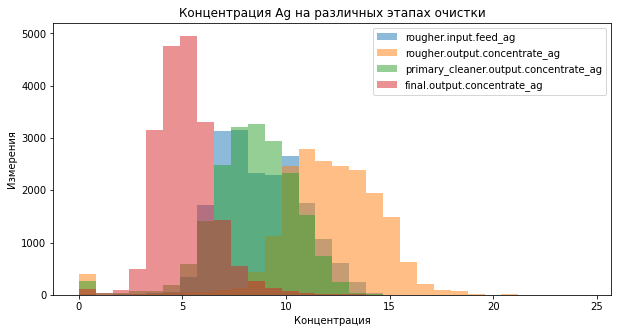

In [117]:
concentrate_ag.plot.hist(bins=30, figsize=(10,5), alpha=0.5)
plt.title('Концентрация Ag на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Измерения');

Как видно из графика, концентрация Ag после очистки уменьшается.

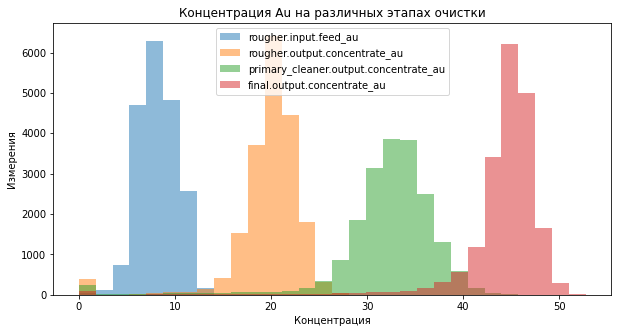

In [118]:
concentrate_au.plot.hist(bins=30, figsize=(10,5), alpha=0.5)
plt.title('Концентрация Au на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Измерения');

Как видно из графика, концентрация Au после очистки увеличивается.

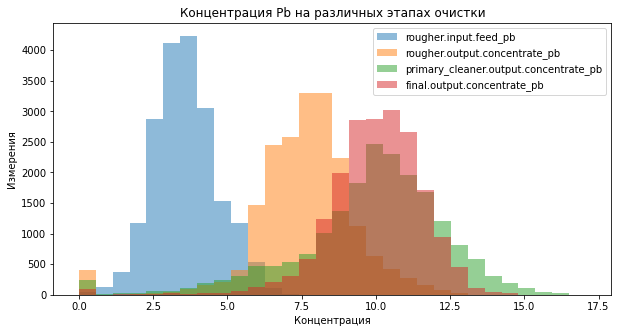

In [119]:
concentrate_pb.plot.hist(bins=30, figsize=(10,5), alpha=0.5)
plt.title('Концентрация Pb на различных этапах очистки')
plt.xlabel('Концентрация')
plt.ylabel('Измерения');

Как видно из графика, концентрация Pb после очистки меняется слабо.

Сравним распределения размеров гранул сырья на обучающей и тестовой выборках:

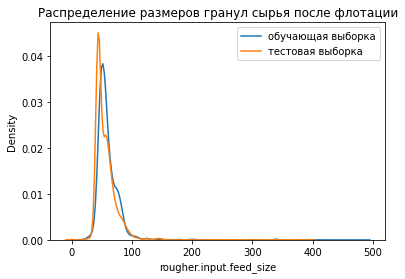

In [120]:
sns.kdeplot(data=gold_recovery_train['rougher.input.feed_size'], alpha=0.5, label='обучающая выборка')
sns.kdeplot(data=gold_recovery_test['rougher.input.feed_size'], alpha=0.5, label='тестовая выборка')
plt.title('Распределение размеров гранул сырья после флотации')
plt.legend();

In [121]:
print('Медианное значение обучающей выборки {} и тестовой {}'.format(gold_recovery_train['rougher.input.feed_size'].median(),
      gold_recovery_test['rougher.input.feed_size'].median()))

Медианное значение обучающей выборки 55.269783890501536 и тестовой 50.8468431600362


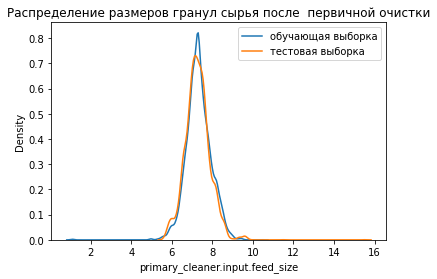

In [122]:
sns.kdeplot(data=gold_recovery_train['primary_cleaner.input.feed_size'], alpha=0.5, label='обучающая выборка')
sns.kdeplot(data=gold_recovery_test['primary_cleaner.input.feed_size'], alpha=0.5, label='тестовая выборка')
plt.title('Распределение размеров гранул сырья после  первичной очистки')
plt.legend();

In [123]:
print('Медианное значение обучающей выборки {} и тестовой {}'.format(gold_recovery_train['primary_cleaner.input.feed_size'].median(),
      gold_recovery_test['primary_cleaner.input.feed_size'].median()))

Медианное значение обучающей выборки 7.289999961853027 и тестовой 7.25


Распределения размеров гранул сырья на обучающей и тестовой выборках схожи. На этапе флотации медианные значения немного различаются. На этапе первичной обработки практически одинаковые.

Исследуем суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. 

In [124]:
rougher_concentrate = gold_recovery_train[
    ['rougher.output.concentrate_ag',
     'rougher.output.concentrate_pb',  
     'rougher.output.concentrate_sol',   
     'rougher.output.concentrate_au']
].sum(axis=1)

primary_cleaner_concentrate = gold_recovery_train[
    ['primary_cleaner.output.concentrate_ag',
     'primary_cleaner.output.concentrate_pb',
     'primary_cleaner.output.concentrate_sol',
     'primary_cleaner.output.concentrate_au']
].sum(axis=1)

final_concentrate = gold_recovery_train[
    ['final.output.concentrate_ag',                       
     'final.output.concentrate_pb',                     
     'final.output.concentrate_sol',
     'final.output.concentrate_au']
].sum(axis=1)

rougher_input_feed =gold_recovery_train[
    ['rougher.input.feed_ag',
     'rougher.input.feed_pb',
     'rougher.input.feed_sol',
     'rougher.input.feed_au']
].sum(axis=1)

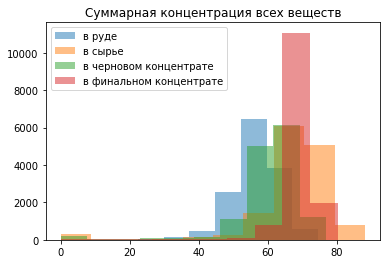

In [125]:
plt.title('Суммарная концентрация всех веществ')
plt.hist(rougher_input_feed,  alpha=0.5, label='в руде')
plt.hist(rougher_concentrate,  alpha=0.5, label='в сырье')
plt.hist(primary_cleaner_concentrate,  alpha=0.5, label='в черновом концентрате')
plt.hist(final_concentrate,  alpha=0.5, label='в финальном концентрате')

plt.legend();

Распределение суммарной концентрации уменьшается в ходе обработки.

**Выводы:**
В ходе обработки сырья концентрация примесей уменьшается, концентрация золота увеличивается.
Распределения размеров гранул сырья на обучающей и тестовой выборках схожи.
Распределение суммарной концентрации уменьшается в ходе обработки.

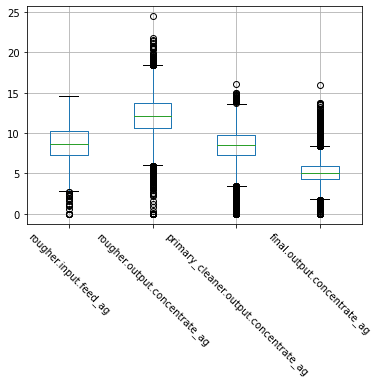

In [126]:
concentrate_ag.boxplot(rot=-45);

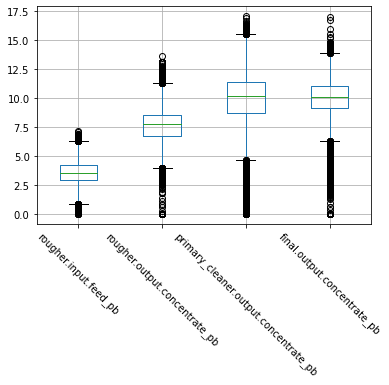

In [127]:
concentrate_pb.boxplot(rot=-45);

Удалим существенные выбросы:

In [129]:
gold_recovery_train = gold_recovery_train[
    (gold_recovery_train['rougher.output.concentrate_ag'] > 7) 
    & (gold_recovery_train['primary_cleaner.output.concentrate_ag'] > 4)
    & (gold_recovery_train['final.output.concentrate_ag'] > 2)
    & (gold_recovery_train['rougher.output.concentrate_pb'] > 4) 
    & (gold_recovery_train['primary_cleaner.output.concentrate_pb'] > 3)
    & (gold_recovery_train['final.output.concentrate_pb'] > 5)
    & (gold_recovery_train['rougher.output.concentrate_au'] > 5) 
    & (gold_recovery_train['primary_cleaner.output.concentrate_au'] > 5)
    & (gold_recovery_train['final.output.concentrate_au'] > 10)
    
]

## Модель

Функция для вычисления sMAPE:

In [130]:
def smape_func(y_true, y_predicted):
    return (
        1 / len(y_true) 
        * np.sum(np.abs(y_true - y_predicted) / ((np.abs(y_true) + np.abs(y_predicted))/2)* 100))

Функция для вычисления итоговой sMAPE:

In [131]:
def smape_total(smape_rougher, smape_final):
    return 0.25 * smape_rougher + 0.75 * smape_final

Создадим вызываемый объект для оценки. Подтянем функцию smape_func для scoring в вычислениях cross_val_score:

In [132]:
smape_scorer = make_scorer(smape_func, greater_is_better=False)

Разобьем обучающую выборку на обучающую и валидационную по признаку 'rougher.output.recovery':

In [133]:
gold_recovery_train

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [134]:
gold_recovery_train = gold_recovery_train.drop(
    ['date',
     'final.output.concentrate_ag',
     'final.output.concentrate_au',
     'final.output.concentrate_pb',
     'final.output.concentrate_sol',
     'final.output.tail_ag',
     'final.output.tail_au',
     'final.output.tail_pb',
     'final.output.tail_sol',
     'primary_cleaner.output.concentrate_ag',
     'primary_cleaner.output.concentrate_au',
     'primary_cleaner.output.concentrate_pb',
     'primary_cleaner.output.concentrate_sol',
     'primary_cleaner.output.tail_ag',
     'primary_cleaner.output.tail_au',
     'primary_cleaner.output.tail_pb',
     'primary_cleaner.output.tail_sol',
     'rougher.calculation.au_pb_ratio',
     'rougher.calculation.floatbank10_sulfate_to_au_feed',
     'rougher.calculation.floatbank11_sulfate_to_au_feed',
     'rougher.calculation.sulfate_to_au_concentrate',
     'rougher.output.concentrate_ag',
     'rougher.output.concentrate_au',
     'rougher.output.concentrate_pb',
     'rougher.output.concentrate_sol',
     'rougher.output.tail_ag',
     'rougher.output.tail_au',
     'rougher.output.tail_pb',
     'rougher.output.tail_sol',
     'secondary_cleaner.output.tail_ag',
     'secondary_cleaner.output.tail_au',
     'secondary_cleaner.output.tail_pb',
     'secondary_cleaner.output.tail_sol'],
     axis=1
)

features_rougher = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_rougher = gold_recovery_train['rougher.output.recovery']

Функция для обучения модели и расчета метрики:

In [135]:
def model_score(model,features,target):  
    scores = cross_val_score(model, features, target, cv=5, scoring=smape_scorer)

    return scores.mean()

Используем для обучения модели алгоритм Линейной регрессии:

In [136]:
model = LinearRegression()
model_score(model, features_rougher, target_rougher)

-6.883081570139223

Используем для обучения модели алгоритм Дерева решений:

In [137]:
param_grid = {'max_depth' : [2,4,6,8,10,12]}

model = DecisionTreeRegressor(random_state=state)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(features_rougher, target_rougher)

print('Наилучший результат метрики с параметрами:', grid_search.best_params_)

Наилучший результат метрики с параметрами: {'max_depth': 4}


In [151]:
model = DecisionTreeRegressor(max_depth=4, random_state=state)
model_score(model, features_rougher, target_rougher)

-7.337163914812075

Используем для обучения модели алгоритм Случайного леса:

In [139]:
# param_grid = {'n_estimators' : [100,200,300],
#               'max_depth'    : [2,4,6]             
#              }

# model = RandomForestRegressor(random_state=state)

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
# grid_search.fit(features_rougher, target_rougher)

# print('Наилучший результат метрики с параметрами:', grid_search.best_params_)

In [140]:
model = RandomForestRegressor(max_depth=6, n_estimators=200, random_state=state)
model_score(model, features_rougher, target_rougher)

-6.172298336573992

Сравним качество моделей с константной моделью:

In [141]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_rougher, target_rougher)
model_score(dummy_model, features_rougher, target_rougher)

-7.562331048923502

**Вывод:** Значение метрики в константной модели хуже, чем в обученных выше.

Разобьем обучающую выборку на обучающую и валидационную по признаку 'final.output.recovery':

In [142]:
features_final = gold_recovery_train.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
target_final = gold_recovery_train['final.output.recovery']

Используем для обучения модели алгоритм Линейной регрессии:

In [143]:
model = LinearRegression()
model_score(model, features_final, target_final)

-10.734251259657047

Используем для обучения модели алгоритм Дерева решений:

In [144]:
param_grid = {'max_depth' : [2,4,6,8,10,12]}

model = DecisionTreeRegressor(random_state=state)

grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
grid_search.fit(features_final, target_final)

print('Наилучший результат метрики с параметрами:', grid_search.best_params_)

Наилучший результат метрики с параметрами: {'max_depth': 2}


In [145]:
model = DecisionTreeRegressor(max_depth=4, random_state=state)
model_score(model, features_final, target_final)

-9.22422555556416

Используем для обучения модели алгоритм Случайного леса:

In [146]:
# param_grid = {'n_estimators' : [100,200,300],
#               'max_depth'    : [2,4,6]             
#              }

# model = RandomForestRegressor(random_state=state)

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring=smape_scorer)
# grid_search.fit(features_final, target_final)

# print('Наилучший результат метрики с параметрами:', grid_search.best_params_)

In [147]:
model = RandomForestRegressor(max_depth=4, n_estimators=300, random_state=state)
model_score(model, features_final, target_final)

-8.599578504318938

Наилучшее значение этапа флотации показала модель RandomForestRegressor с max_depth=6, n_estimators=200, для финального -  RandomForestRegressor с max_depth=4, n_estimators=300.

Сравним качество моделей с константной моделью:

In [148]:
dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_final, target_final)
model_score(dummy_model, features_final, target_final)

-9.905055810589293

**Вывод:** Значение метрики в константной модели значительно хуже, чем в обученных выше.

Проверим модели на тестовой выборке:

In [149]:
features_rougher_test = gold_recovery_test.drop(['rougher.output.recovery', 'final.output.recovery', 'date'], axis=1)
target_rougher_test = gold_recovery_test['rougher.output.recovery']
features_final_test = gold_recovery_test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_final_test = gold_recovery_test['final.output.recovery']

Посчитаем итоговую sMAPE:

In [152]:
model_rougher = RandomForestRegressor(max_depth=6, n_estimators=200, random_state=state)
model_rougher.fit(features_rougher, target_rougher)
rougher_predicted = model_rougher.predict(features_rougher_test)

model_final = RandomForestRegressor(max_depth=4, n_estimators=300, random_state=state)
model_final.fit(features_final, target_final)
final_predicted = model_final.predict(features_final_test)

smape_rougher = abs(smape_func(target_rougher_test, rougher_predicted))
smape_final = abs(smape_func(target_final_test, final_predicted))

print('Значения sMAPE в начале обработки {} и в конце обработки {}'.format(smape_rougher,smape_final))
print('Итоговое sMAPE:', smape_total(smape_rougher, smape_final))

Значения sMAPE в начале обработки 7.846982527401307 и в конце обработки 9.825371260908808
Итоговое sMAPE: 9.330774077531933


**Выводы:**
Для признака 'rougher.output.recovery' лучший показатель метрики sMAPE 7,84 мы получили в моделе случайного дерева с параметрами max_depth=6, n_estimators=200. Для признака 'final.output.recovery' лучший показатель метрики sMAPE равен 9.82 в моделе случайного дерева с параметрами max_depth=4, n_estimators=300. Итоговое значение метрики на тестовой выборке равно 9.33.

**Итоговые выводы:**
В рамках проекта было проведено исследование данных по обработке золотосодержащей руды, целью было смоделировать процесс восстановления золота из золотосодержащей руды, предсказывающий эффективность обогащения руды.

В ходе проекта:
- Была проведена предобработка данных. 
- Были заполнены пропущенные значения. 
- Добавлены целевые признаки в тестовую выборку.
- Проведена проверка значений эффективности обогащения (эффективность рассчитана корректно)

Исследование концентрации металлов (Au, Ag, Pb) на разных стадиях обработки показало уменьшение концентрации к финальному этапу очистки Ag, Pb, и увеличение концентрации Au.

Распределения размеров гранул сырья на обучающей и тестовой выборках по форме распределения совпадают.

Обучение моделей проводилось для целевых признаков 'rougher.output.recovery' и 'final.output.recovery' отдельно с помощью трех алгоритмов: LinearRegression, DecisionTreeRegressor, RandomForestRegressor. Оценкаих качества кросс-валидацией показало лучшую модель для признака 'rougher.output.recovery' случайного дерева с параметрами max_depth=6, n_estimators=200 с метрикой sMAPE 6.17. Для признака 'final.output.recovery' **лучший показатель метрики sMAPE равен 8.59** в моделе случайного дерева с параметрами **max_depth=4, n_estimators=300**.

Итоговое значение метрики **на тестовой выборке** мы получили равным **9.33**.
